In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, StackingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer
from sklearn.base import RegressorMixin, ClassifierMixin, BaseEstimator
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

In [4]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module6_exercise_train.csv')
download_file(test_data_url, 'module6_exercise_test.csv')

Downloaded module6_exercise_train.csv from https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_train.csv
Downloaded module6_exercise_test.csv from https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_test.csv


In [8]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
data_test = pd.read_csv('module6_exercise_test.csv', index_col='index')

In [10]:
y = data_train.pop('end_of_day_return')
X = data_train.copy()

In [12]:
def weighted_accuracy(y_true, y_pred):
    weights = np.abs(y_true)
    
    # Compute the sign of true and predicted values
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    
    # Correct predictions where the sign of the true and predicted values match
    correct_predictions = sign_true == sign_pred
    
    # Compute the weighted accuracy
    weighted_acc = np.sum(weights * correct_predictions) / np.sum(weights)
    
    return weighted_acc

In [14]:
# Function to plot the evaluation results
def plot_results(mse_train, mse_test, w_acc_train, w_acc_test):
    plt.figure(figsize=(12, 6))

    # MSE plot
    plt.subplot(1, 2, 1)
    plt.plot(mse_train, label="Train MSE", marker='o')
    plt.plot(mse_test, label="Test MSE", marker='o')
    plt.fill_between(range(len(mse_train)), np.min(mse_train), np.max(mse_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(mse_test)), np.min(mse_test), np.max(mse_test), color='orange', alpha=0.1)
    plt.title("MSE over Folds")
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # weighted_accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(w_acc_train, label="Train weighted_accuracy", marker='o')
    plt.plot(w_acc_test, label="Test weighted_accuracy", marker='o')
    plt.fill_between(range(len(w_acc_train)), np.min(w_acc_train), np.max(w_acc_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(w_acc_test)), np.min(w_acc_test), np.max(w_acc_test), color='orange', alpha=0.1)
    plt.title("weighted_accuracy over Folds")
    plt.xlabel("Fold")
    plt.ylabel("weighted_accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
def plot_multi_model_results(results):
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    # Colors for train and test
    train_color = 'skyblue'
    test_color = 'lightgreen'
    
    # Plot MSE
    ax1.set_title('Mean Squared Error (MSE) Comparison', fontsize=16)
    ax1.set_ylabel('MSE', fontsize=12)
    ax1.set_xlabel('Models', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot weighted_accuracy
    ax2.set_title('weighted_accuracy Comparison', fontsize=16)
    ax2.set_ylabel('weighted_accuracy', fontsize=12)
    ax2.set_xlabel('Models', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    x = np.arange(len(results))
    width = 0.35
    
    for i, (model_name, scores) in enumerate(results.items()):
        # MSE
        mse_train = scores['mse_train']
        mse_test = scores['mse_test']
        
        ax1.bar(x[i] - width/2, np.mean(mse_train), width, label='Train' if i == 0 else "", 
                color=train_color, alpha=0.7)
        ax1.bar(x[i] + width/2, np.mean(mse_test), width, label='Test' if i == 0 else "", 
                color=test_color, alpha=0.7)
        
        ax1.errorbar(x[i] - width/2, np.mean(mse_train), 
                     yerr=[[np.mean(mse_train)-np.min(mse_train)], [np.max(mse_train)-np.mean(mse_train)]], 
                     fmt='none', ecolor='black', capsize=5)
        ax1.errorbar(x[i] + width/2, np.mean(mse_test), 
                     yerr=[[np.mean(mse_test)-np.min(mse_test)], [np.max(mse_test)-np.mean(mse_test)]], 
                     fmt='none', ecolor='black', capsize=5)
        
        # weighted_accuracy
        w_acc_train = scores['w_acc_train']
        w_acc_test = scores['w_acc_test']
        
        ax2.bar(x[i] - width/2, np.mean(w_acc_train), width, label='Train' if i == 0 else "", 
                color=train_color, alpha=0.7)
        ax2.bar(x[i] + width/2, np.mean(w_acc_test), width, label='Test' if i == 0 else "", 
                color=test_color, alpha=0.7)
        
        ax2.errorbar(x[i] - width/2, np.mean(w_acc_train), 
                     yerr=[[np.mean(w_acc_train)-np.min(w_acc_train)], [np.max(w_acc_train)-np.mean(w_acc_train)]], 
                     fmt='none', ecolor='black', capsize=5)
        ax2.errorbar(x[i] + width/2, np.mean(w_acc_test), 
                     yerr=[[np.mean(w_acc_test)-np.min(w_acc_test)], [np.max(w_acc_test)-np.mean(w_acc_test)]], 
                     fmt='none', ecolor='black', capsize=5)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(results.keys(), rotation=45, ha='right')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results.keys(), rotation=45, ha='right')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [16]:
# Function to handle train-test evaluation in a fold
def train_and_evaluate(X_train, X_test, y_train, y_test, model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on train set
    y_pred_train = model.predict(X_train)
    # Make predictions on train set
    y_pred_test = model.predict(X_test)
    
    # Compute MSE for train and test
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Compute weighted_accuracy
    
    w_acc_train = weighted_accuracy(y_train, y_pred_train)
    w_acc_test = weighted_accuracy(y_test, y_pred_test)
    
    return mse_train, mse_test, w_acc_train, w_acc_test


def run_multi_model_cv(X, y, models, n_splits=5):
    fold = KFold(n_splits=n_splits)
    results = {name: {'mse_train': [], 'mse_test': [], 'w_acc_train': [], 'w_acc_test': []} 
               for name in models.keys()}
    
    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        for name, model in models.items():
            mse_train, mse_test, w_acc_train, w_acc_test = train_and_evaluate(
                X_train, X_test, y_train, y_test, model
            )
            results[name]['mse_train'].append(mse_train)
            results[name]['mse_test'].append(mse_test)
            results[name]['w_acc_train'].append(w_acc_train)
            results[name]['w_acc_test'].append(w_acc_test)
        # Find the model with the best mean w_acc test score
    best_mean_w_acc = -1
    best_model = None
    best_min_w_acc = None
    best_max_w_acc = None
    
    for name, result in results.items():
        w_acc_test_scores = result['w_acc_test']
        mean_w_acc_test = sum(w_acc_test_scores) / len(w_acc_test_scores)  # Calculate mean w_acc score
        min_w_acc_test = min(w_acc_test_scores)  # Minimum w_acc score
        max_w_acc_test = max(w_acc_test_scores)  # Maximum w_acc score
        
        if mean_w_acc_test > best_mean_w_acc:
            best_mean_w_acc = mean_w_acc_test
            best_min_w_acc = min_w_acc_test
            best_max_w_acc = max_w_acc_test
            best_model = name
    
    # Print the best mean w_acc test score, min, max, and the associated model
    print(f"Best mean w_acc test score: {best_mean_w_acc:.4f} by model: {best_model}")
    print(f"Min w_acc test score: {best_min_w_acc:.4f}, Max w_acc test score: {best_max_w_acc:.4f}")
    return results

# Classification

In [130]:
modelsClassif = {
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'KNN Classifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'Logistic Regression': LogisticRegression(),
}

In [68]:
yClassif = np.sign(y)
resultsClassif = run_multi_model_cv(X, yClassif, modelsClassif)

Best mean w_acc test score: 0.5152 by model: Random Forest Classifier
Min w_acc test score: 0.4988, Max w_acc test score: 0.5275


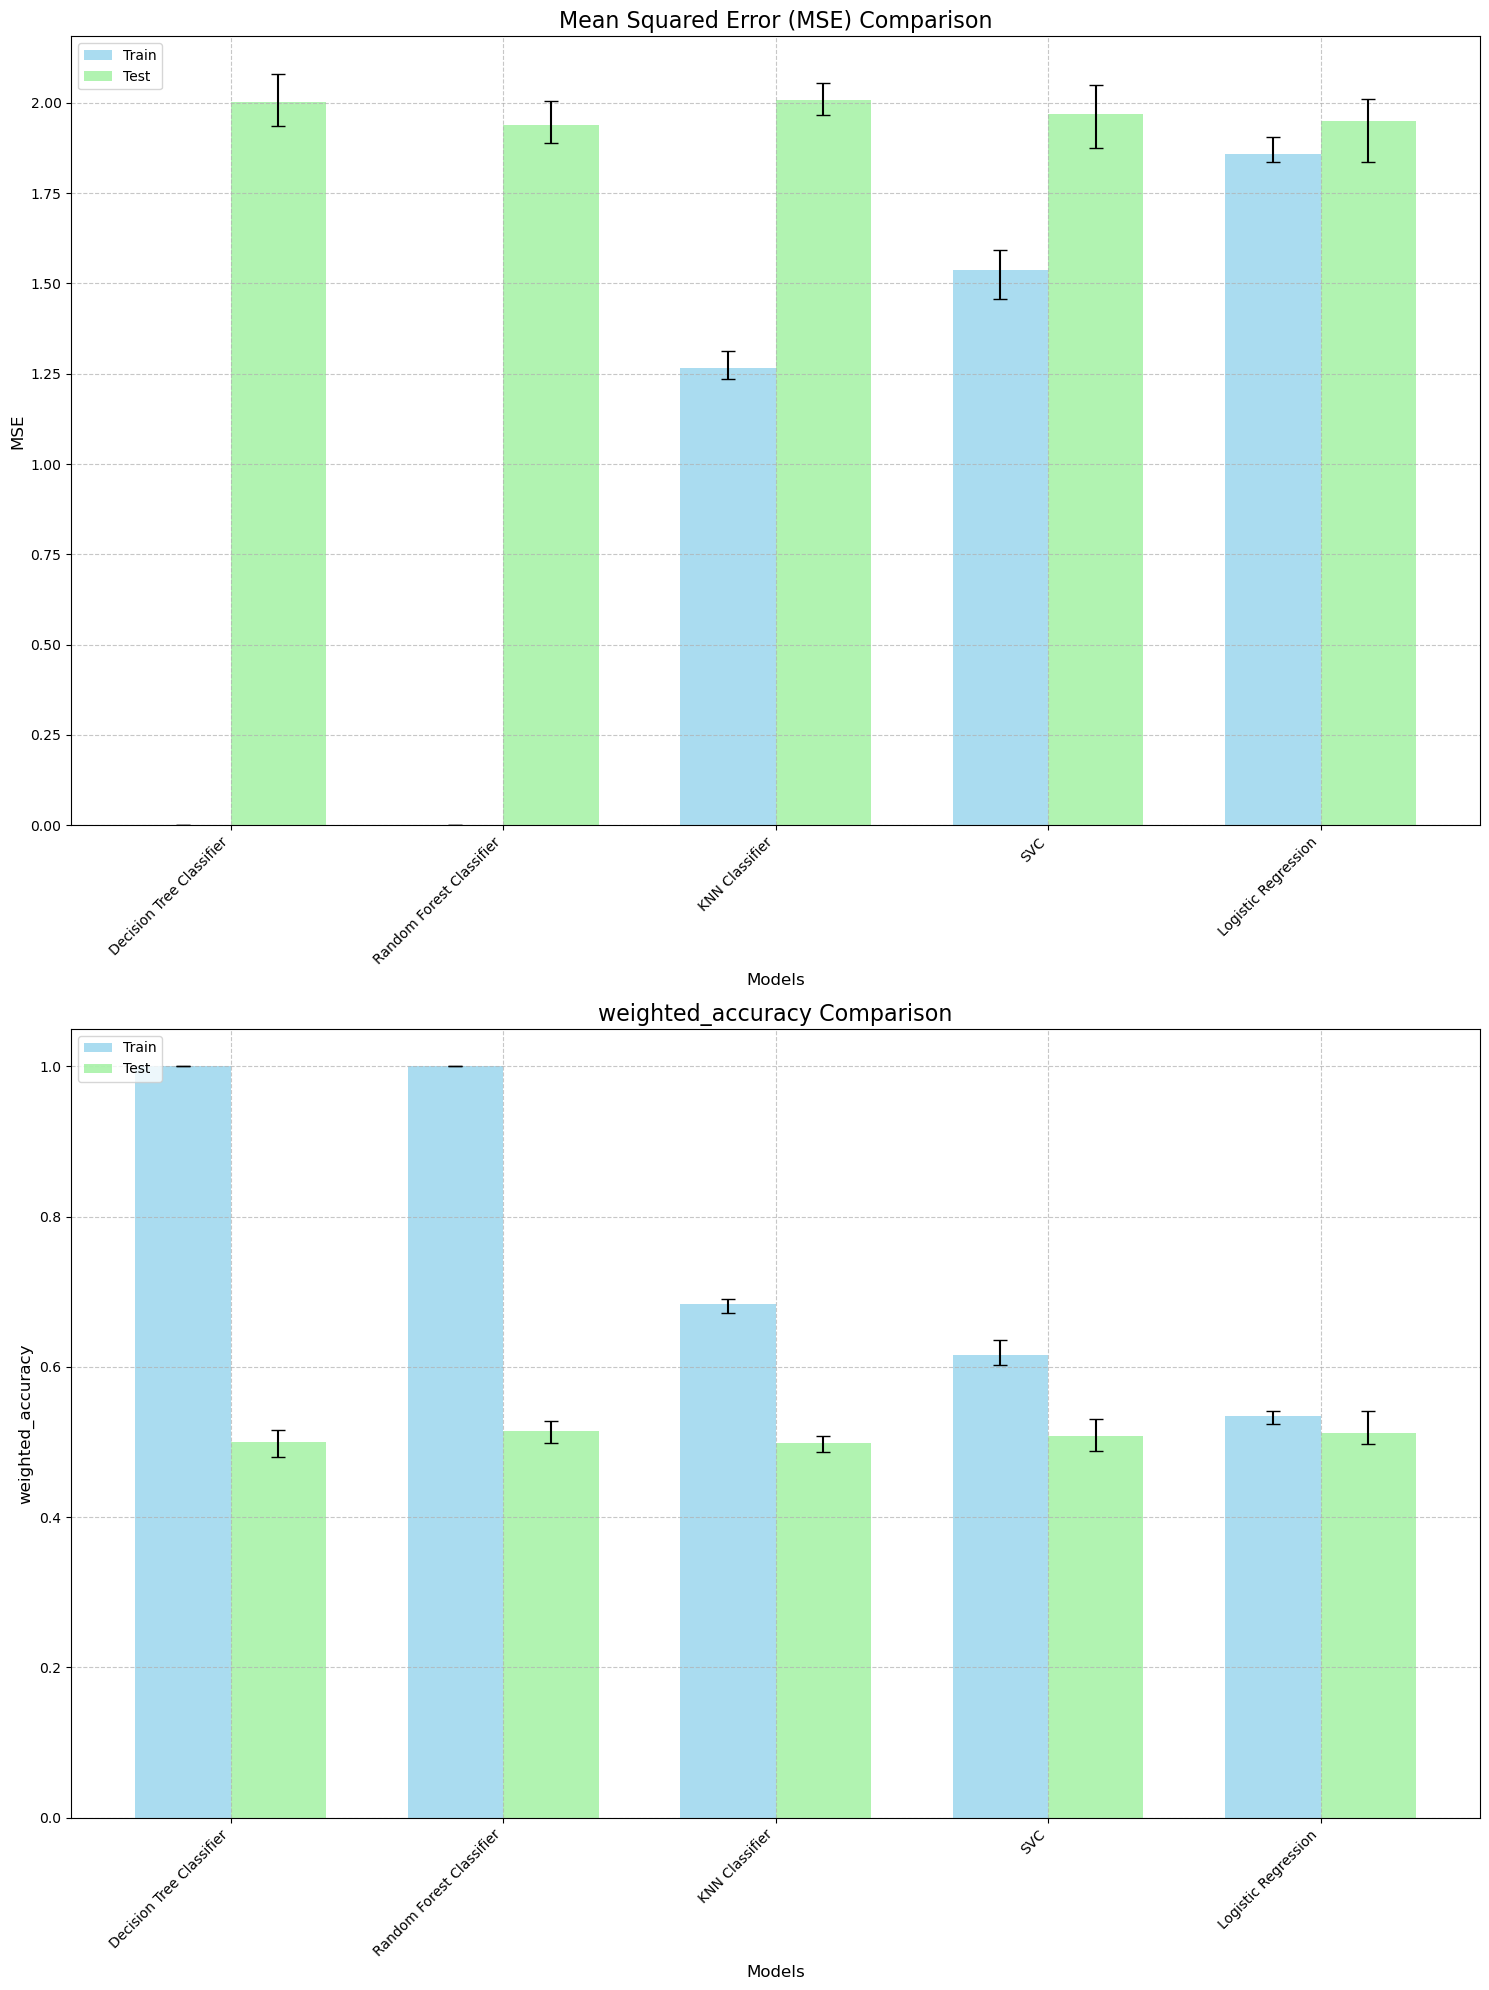

In [72]:
plot_multi_model_results(resultsClassif)

# Regression

In [132]:
modelsReg = {
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=5000),
    #'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(),
    'KNNRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
}

In [134]:
# Run cross-validation for regression models
results = run_multi_model_cv(X, y, modelsReg)

Best mean w_acc test score: 0.5254 by model: Ridge
Min w_acc test score: 0.4869, Max w_acc test score: 0.5544


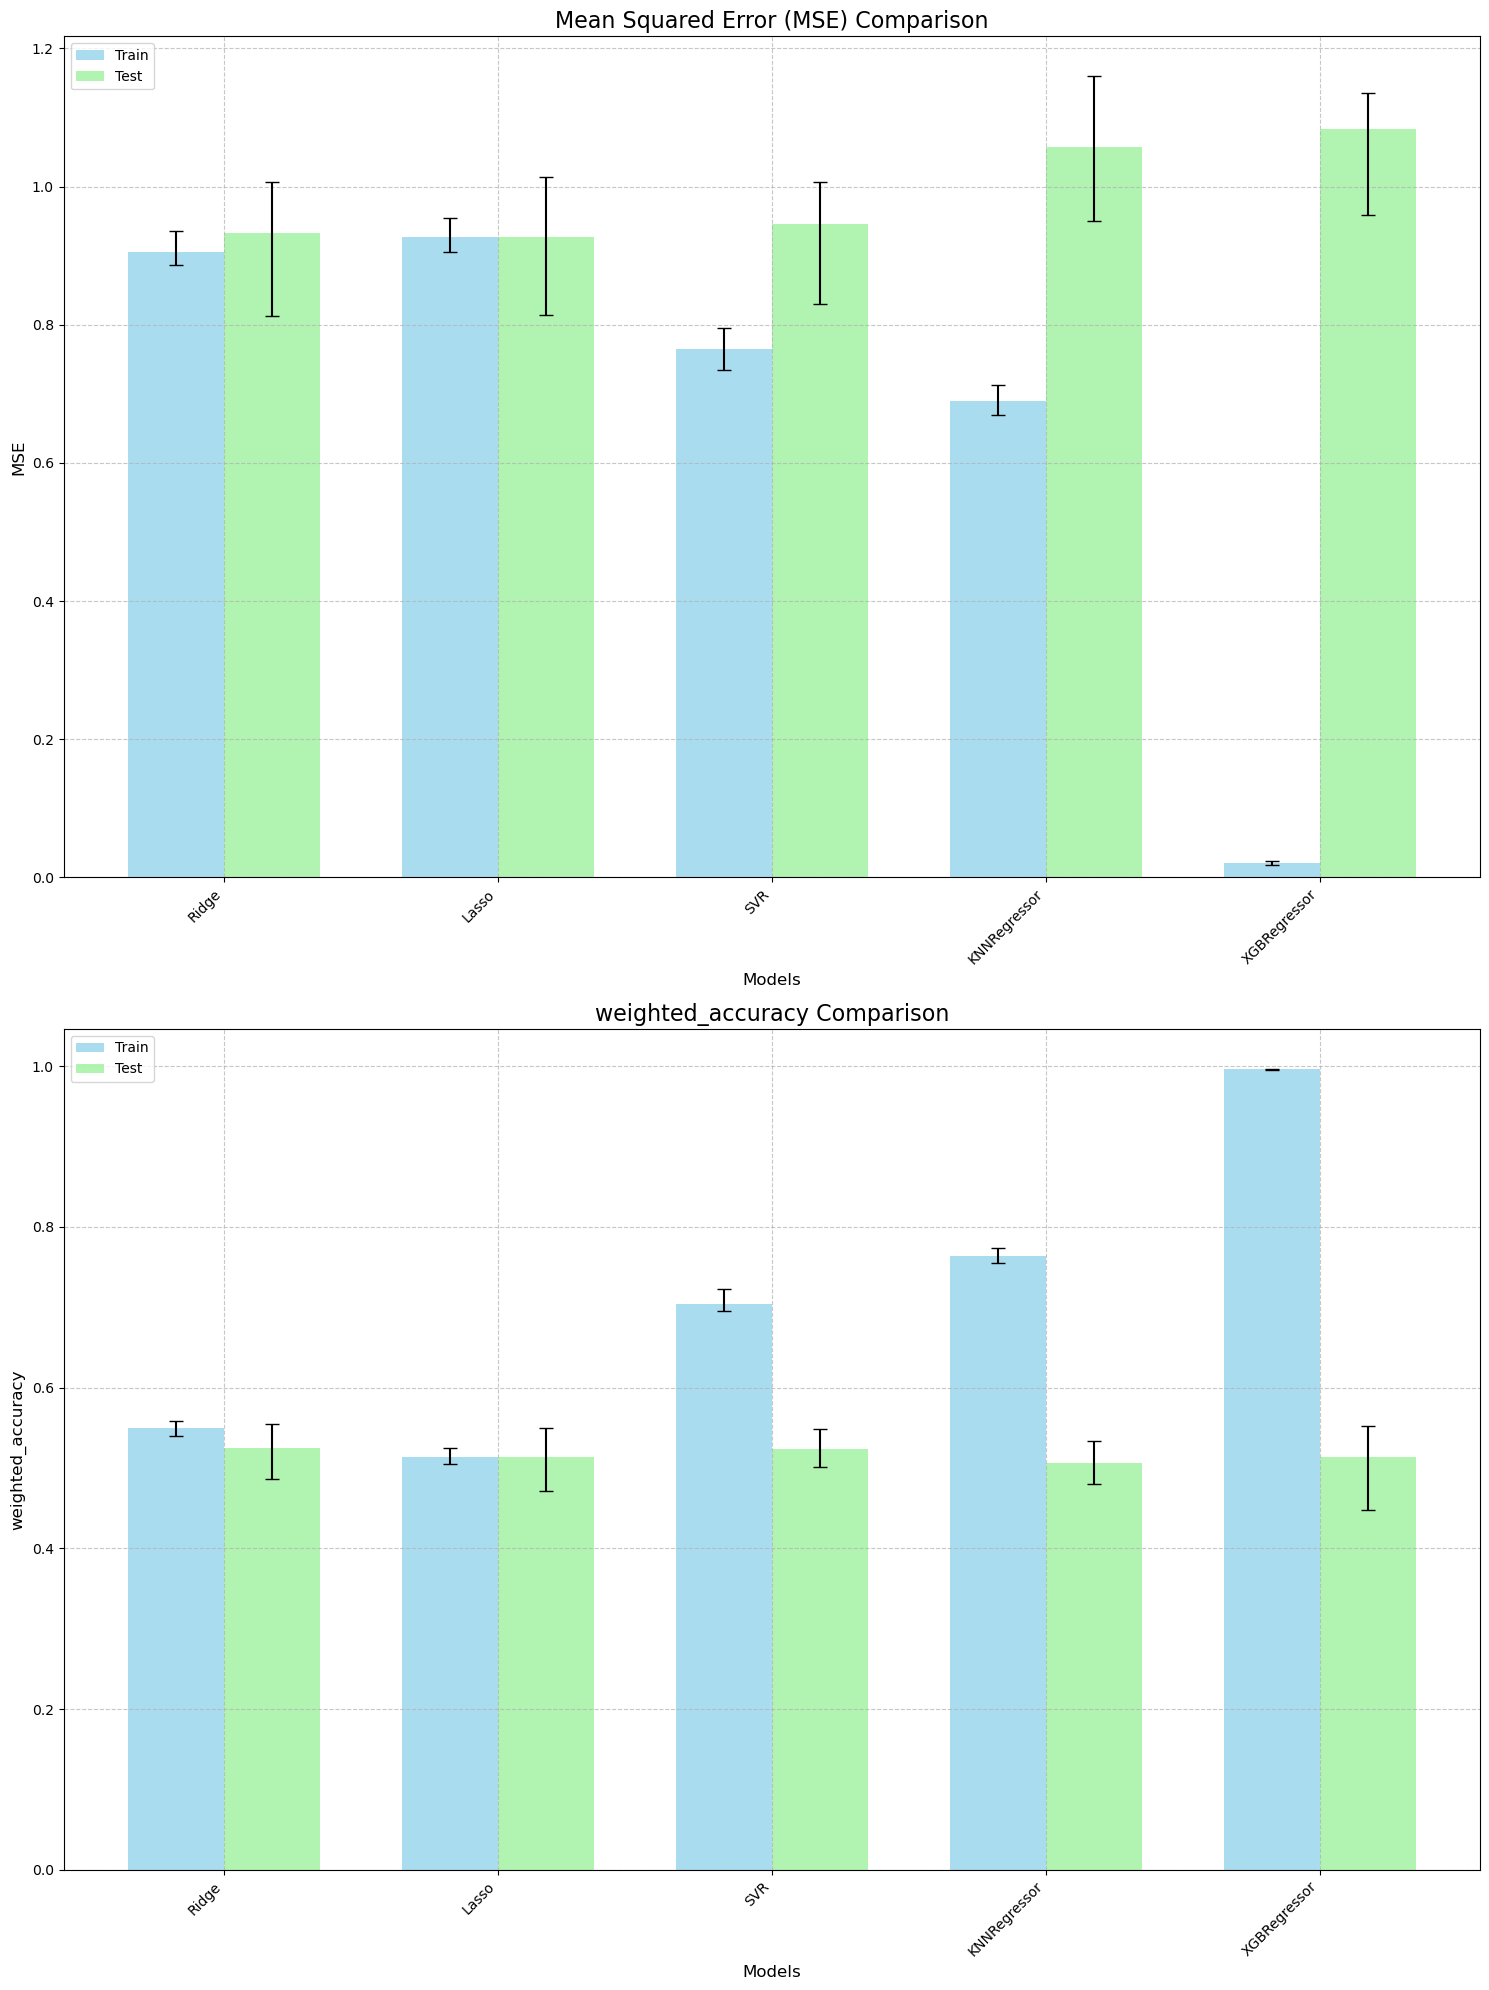

In [136]:
# Plot MSE results for regression models
plot_multi_model_results(results)

# Baysien Optimisation d'hyperparametre pour les regressions

In [127]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper

# Define the search spaces for each model
spaces_reg = {
    #'RandomForestRegressor': {
    #    'n_estimators': Integer(50, 200),
    #    'max_depth': Integer(5, 20),
    #    'min_samples_split': Integer(2, 10),
    #    'min_samples_leaf': Integer(1, 10)
    #},
    'XGBRegressor': {
        'n_estimators': Integer(30, 100),
        'max_depth': Integer(10, 40),
        'learning_rate': Real(0.01, 2.0, 'log-uniform'),
        'subsample': Real(0.5, 1.0, 'uniform'),
        'colsample_bytree': Real(0.5, 1.0, 'uniform')
    },
    'SVR': {
        'C': Real(0.05, 0.5, 'log-uniform'),  
        'epsilon': Real(0.0001, 0.01, 'log-uniform'), 
        'kernel': Categorical(['linear', 'rbf'])  
    },
    'KNNRegressor': {
        'n_neighbors': Integer(5, 20),
        'weights': Categorical(['uniform', 'distance']),
        'p': Integer(1, 2)
    },
    'Lasso': {
        'alpha': Real(0.001, 0.1, 'log-uniform')
    },
    'Ridge': {
        'alpha': Real(0.01, 10.0, 'log-uniform'),
    }
}
delta_stopper = DeltaYStopper(delta=0.001, n_best=10)
models_opt = {}
def optimizer_callback(res):
    if len(res.func_vals) % 5 == 0:  # Print every 5 iterations
        print(f"Iteration {len(res.func_vals)}: Best score = {-res.fun:.4f}")
# Function to optimize models
def optimize_model(X, y, model, space, n_iter=100):
    kfold = KFold(n_splits=5)
    
    scorer = make_scorer(weighted_accuracy)
    
    opt = BayesSearchCV(
        model,
        space,
        n_iter=n_iter,
        n_points=5,
        cv=kfold,
        n_jobs=-1,
        scoring=scorer,
        random_state=42
    )
    
    opt.fit(X, y, callback=[optimizer_callback, delta_stopper])
    
    return opt

for name, model in modelsReg.items():
    print(f"Optimizing {name}...")
    opt = optimize_model(X, y, model, spaces_reg[name])
    models_opt[name] = opt
    print(f"Best parameters: {opt.best_params_}")
    print(f"Best score: {opt.best_score_:.4f}")
    print()

NameError: name 'modelsReg' is not defined

In [150]:
models_opt = {}

models_opt['XGBRegressor'] = {
    'estimator': XGBRegressor(**{'colsample_bytree': 0.6537243787088336, 'learning_rate': 0.03201686796962217, 'max_depth': 40, 'n_estimators': 100, 'subsample': 0.5}),
    'best_params_': {'colsample_bytree': 0.6537243787088336, 'learning_rate': 0.03201686796962217, 'max_depth': 40, 'n_estimators': 100, 'subsample': 0.5},
    'best_score_': 0.5412
}


models_opt['SVR'] = {
    'estimator': SVR(**{'C': 0.4476561396767105, 'epsilon': 0.0006664514296187206, 'kernel': 'linear'}),
    'best_params_': {'C': 0.4476561396767105, 'epsilon': 0.0006664514296187206, 'kernel': 'linear'},
    'best_score_': 0.5379
}

models_opt['KNNRegressor'] = {
    'estimator': KNeighborsRegressor(**{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}),
    'best_params_': {'n_neighbors': 20, 'p': 1, 'weights': 'distance'},
    'best_score_': 0.5272
}

models_opt['Lasso'] = {
    'estimator': Lasso(**{'alpha': 0.015857866441913}),
    'best_params_': {'alpha': 0.015857866441913},
    'best_score_': 0.5302
}

models_opt['Ridge'] = {
    'estimator': Ridge(**{'alpha': 6.2893244081003825}),
    'best_params_': {'alpha': 6.2893244081003825},
    'best_score_': 0.5256
}
models_reg = {}
for name, opt in models_opt.items():
    model_class = type(opt["estimator"])  # Get the model class (e.g., RandomForestRegressor)
    best_params = opt["best_params_"]  # Get the best parameters from the optimization

    # Add the model with the best parameters to the new dictionary
    models_reg[f"{name} opt"] = model_class(**best_params)
results = run_multi_model_cv(X, y, models_reg)

Best mean w_acc test score: 0.5412 by model: XGBRegressor opt
Min w_acc test score: 0.4945, Max w_acc test score: 0.5881


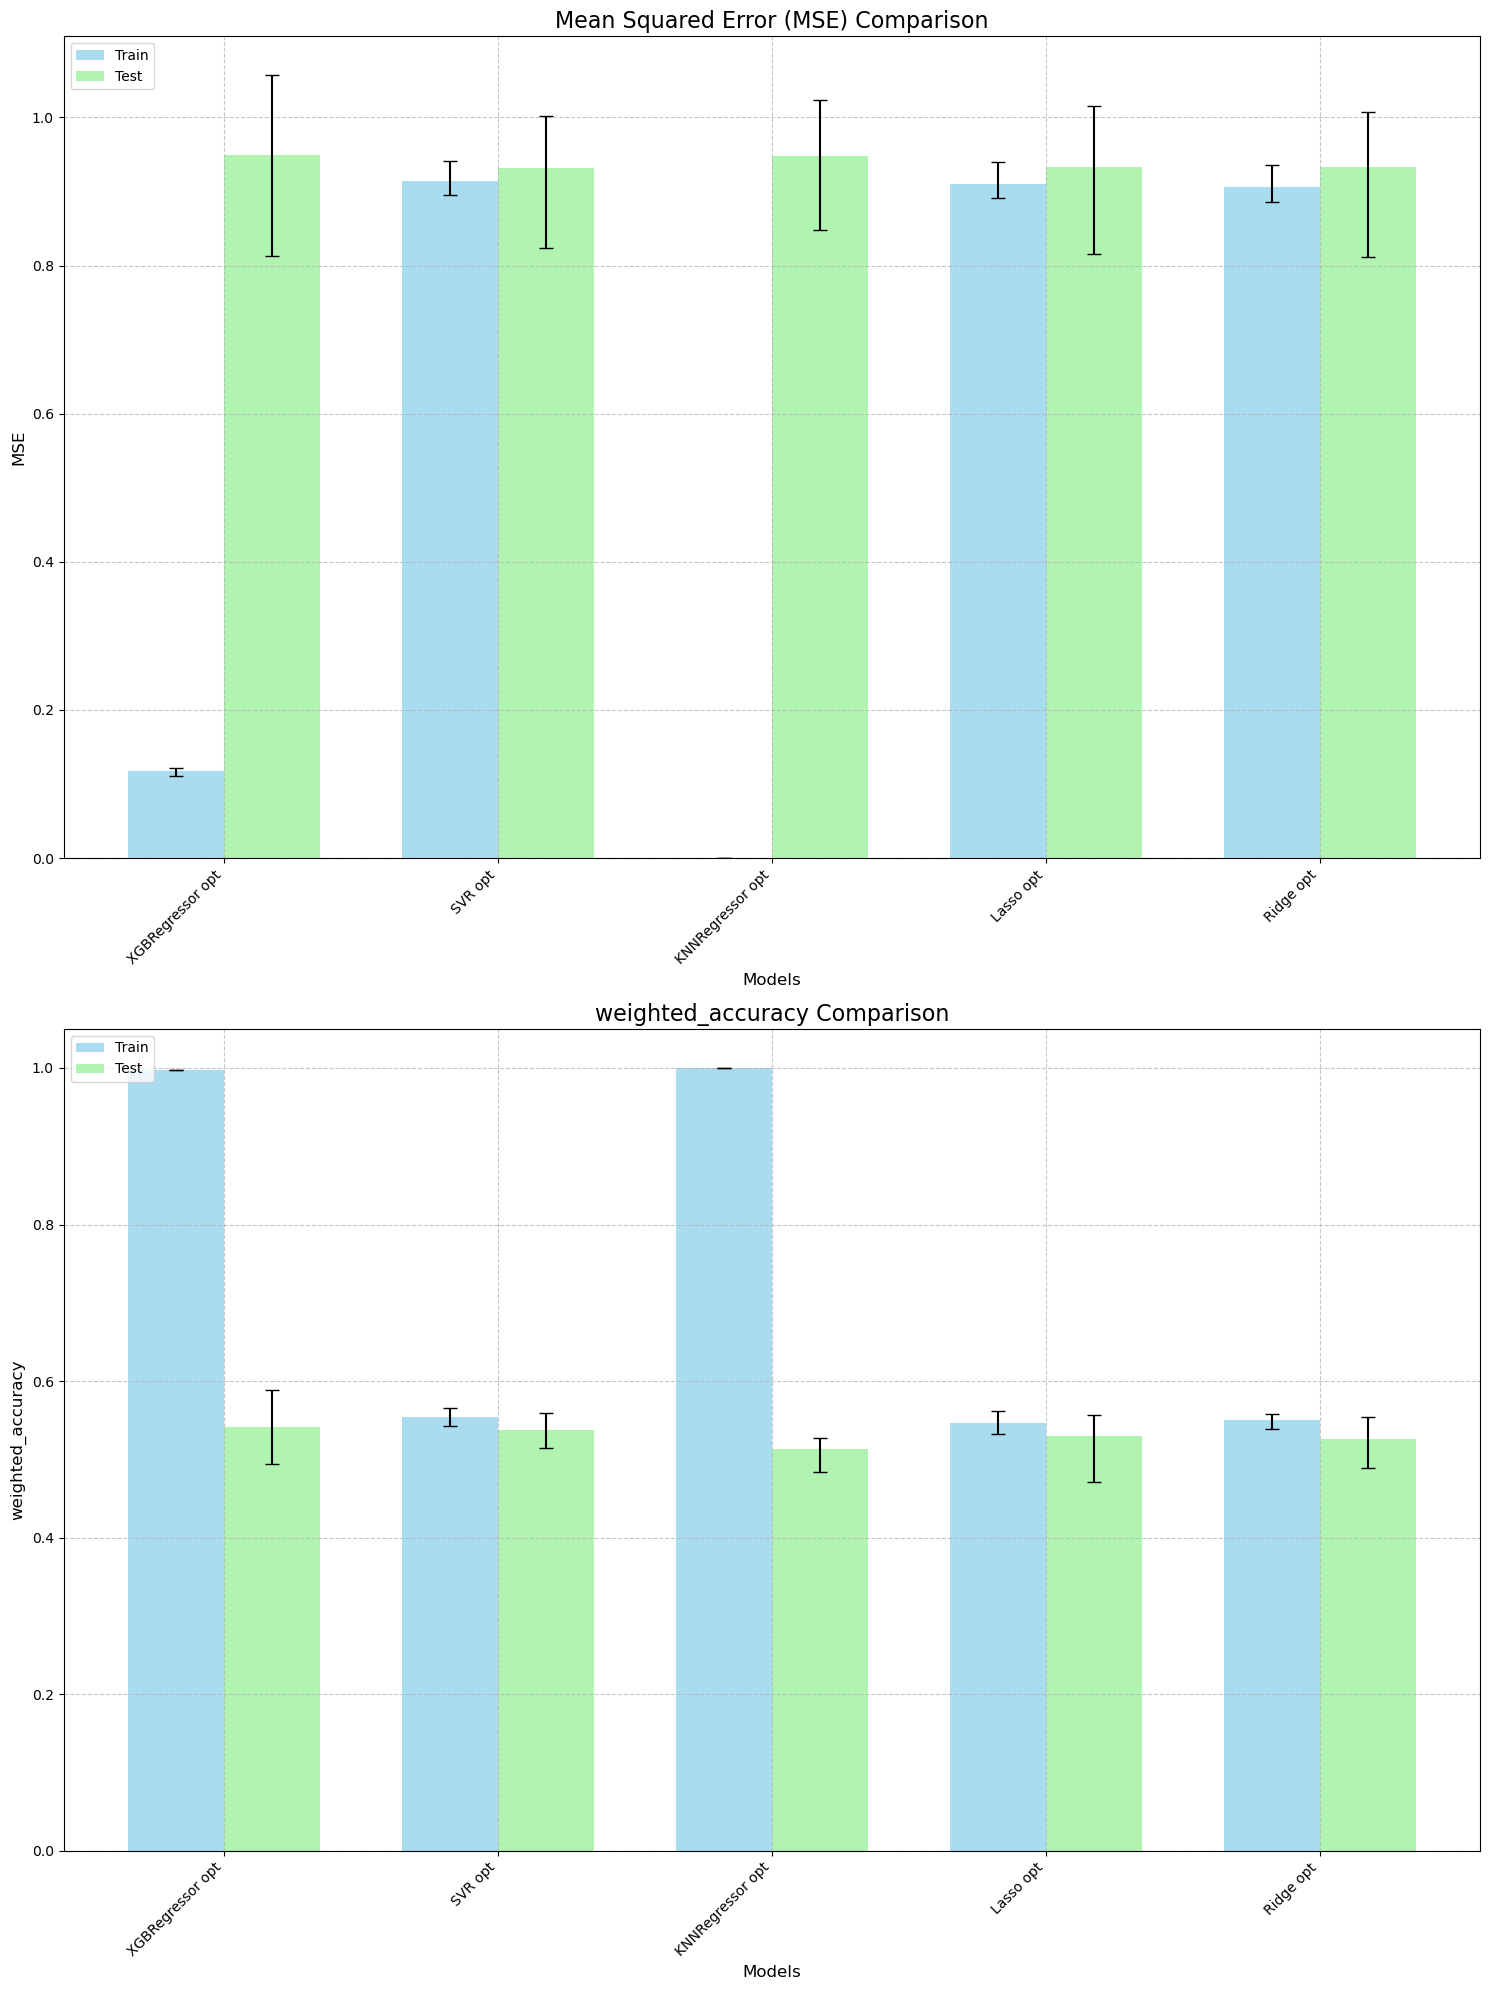

In [152]:
plot_multi_model_results(results)

## Résultat

Le meilleur modèle est donné par :

```python
XGBRegressor(
    **{
        'colsample_bytree': 0.6537,
        'learning_rate': 0.0320,
        'max_depth': 40,
        'n_estimators': 100,
        'subsample': 0.5
    }
)
```
Ce modèle atteint une weighted accuracy moyenne de 0.5412

## Bagging Classification

In [32]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
yClassif = np.sign(y)
X_train, X_test, y_train, y_test = train_test_split(X, yClassif, test_size=0.2, random_state=42)
# Create and train the BaggingClassifier
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=-1,
    random_state=42
)
bagging.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = bagging.predict(X_test)
accuracy = weighted_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4775


## Stacking Classification

In [148]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
# Create and train the StackingClassifier
estimators = [
    ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('svc', SVC(probability=True))
]
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    stack_method='predict_proba'
)
stacking.fit(X_train, y_train)
# Make predictions and evaluate
y_pred = stacking.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5225
